In [98]:
import numpy as np
import scipy.interpolate as intp
import matplotlib.pyplot as plt
from numpy import cos, sin

In [117]:
# get color matching functions
MF = np.genfromtxt("CMF_5nm.csv", delimiter=',')
cmf = MF[:, 1:4]
abeam = np.ones(cmf.shape[0])
wtpt = cmf.T@abeam

In [118]:
# add purple points
ucmf = [c/np.linalg.norm(c) for c in cmf]
coeffs = np.linspace(0, 1, 30)
c1 = cmf[-1]/np.linalg.norm(cmf[-1])
c0 = cmf[0]/np.linalg.norm(cmf[0])
mixture = []
for c in coeffs:
    mix = c*c0 + (1-c)*c1
    mixture.append(mix/np.linalg.norm(mix))
units = np.concatenate((ucmf, mixture))

In [120]:
# spline from points
I = np.linspace(0, 2*np.pi, len(units))
x_spline = intp.make_interp_spline(I, units[:, 0])
y_spline = intp.make_interp_spline(I, units[:, 1])
z_spline = intp.make_interp_spline(I, units[:, 2])

In [121]:
trials = 100000

In [122]:
vec = lambda s: np.array([x_spline(s), y_spline(s), z_spline(s)])
input_pts = np.linspace(0, 2*np.pi, trials + 1)
spline_pts = vec(input_pts)

the white point is not on an axis. perhaps we can rotate the axis!?

In [232]:
# want to move [x,y,z] to [0,r,0]
uwtpt = wtpt/np.linalg.norm(wtpt)
uwtpt

array([0.57731787, 0.57728924, 0.57744368])

In [233]:
# http://scipp.ucsc.edu/~haber/ph216/rotation_12.pdf
def get_rot_matrix(n, t):
    n1,n2,n3 = n[0],n[1],n[2]
    return np.array([
        [cos(t) + n1*n1 * (1 - cos(t)), n1*n2*(1 - cos(t)) - n3*sin(t), n1*n3*(1 - cos(t)) + n2*sin(t)],
        [n1*n2*(1 - cos(t)) + n3*sin(t), cos(t) + n2*n2*(1 - cos(t)), n2*n3*(1 - cos(t)) - n1*sin(t)],
        [n1*n3*(1 - cos(t)) - n2*sin(t), n2*n3*(1 - cos(t)) + n1*sin(t), cos(t) + n3*n3*(1 - cos(t))],
    ])

In [234]:
cross = np.cross(uwtpt, [0,1,0])
theta = np.arccos(np.dot(uwtpt, [0,1,0]))
assert np.allclose(uwtpt, get_rot_matrix(cross/np.linalg.norm(cross), -theta) @ [0,1,0])
assert np.allclose([0,1,0], get_rot_matrix(cross/np.linalg.norm(cross), theta) @ uwtpt)

In [235]:
rot = get_rot_matrix(cross/np.linalg.norm(cross), theta)

In [236]:
# some extra magic to make sure we get the whole angle from [0,2pi)
get_theta = lambda v:  np.sign(v[2])*np.arccos(v[0] / (v[0]**2 + v[2]**2)**0.5) \
     - np.sign(v[2]) * np.pi + np.pi

In [237]:
thetas = get_theta(rot @ spline_pts)

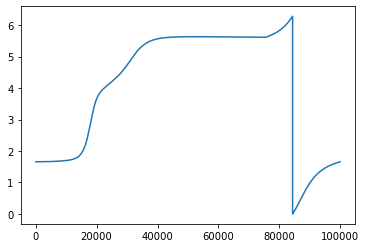

In [238]:
plt.plot(thetas)

What next? Were we going to cut them evenly to get evenly spaced characteristic points?

In [174]:
unit_vectors = [c/np.linalg.norm(c) for c in MF[:, 1:]]

In [175]:
unit_vectors

[array([0.19989786, 0.02198637, 0.97957003]),
 array([0.19940422, 0.0225193 , 0.97965853]),
 array([0.19797038, 0.02192392, 0.97996279]),
 array([0.19625343, 0.02057178, 0.98033739]),
 array([0.19476141, 0.01975034, 0.98065178]),
 array([0.1923011 , 0.01900623, 0.9811519 ]),
 array([0.18998307, 0.01892029, 0.98160504]),
 array([0.18727882, 0.01965793, 0.98211008]),
 array([0.18465726, 0.02100181, 0.98257856]),
 array([0.18147028, 0.02338154, 0.98311843]),
 array([0.17863853, 0.02582028, 0.98357592]),
 array([0.17535157, 0.02946082, 0.98406498]),
 array([0.17174471, 0.03447186, 0.98453819]),
 array([0.16727485, 0.04283494, 0.98497934]),
 array([0.16089319, 0.05512418, 0.98543123]),
 array([0.15314465, 0.07314034, 0.98549338]),
 array([0.14224744, 0.10225956, 0.98453474]),
 array([0.12676772, 0.15062606, 0.98042936]),
 array([0.10485279, 0.2291143 , 0.96773578]),
 array([0.07664979, 0.34399756, 0.93583678]),
 array([0.04392617, 0.5014796 , 0.86405364]),
 array([0.01683351, 0.67608874, 0.